In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [85]:
# Загрузил данные из файла covid_usa.csv, проверил данные на пропуски
data = pd.read_csv('covid_usa.csv', index_col=[0], parse_dates=[0])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 674 entries, 2020-05-01 to 2022-03-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   674 non-null    int64
dtypes: int64(1)
memory usage: 10.5 KB


,cases
date,
2020-05-01,33970
2020-05-02,29474
2020-05-03,26140
2020-05-04,21962
2020-05-05,23709


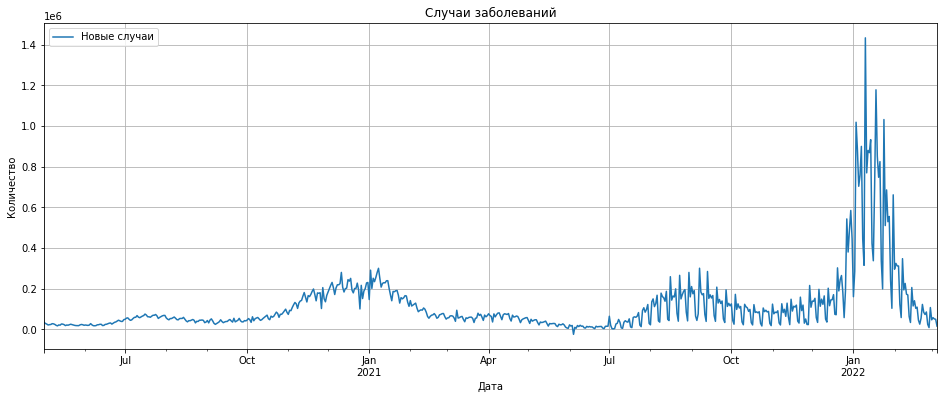

In [69]:
data.plot(figsize=(16,6), 
            grid=True, 
            xlabel='Дата',
            ylabel='Количество',
            title='Случаи заболеваний')
plt.legend(['Новые случаи'])
plt.show()

На графике видна некоторая сезонность:
Первая волна заболеваимости в июле и вторая волна более сильной заболеваимости с пиком в январе.

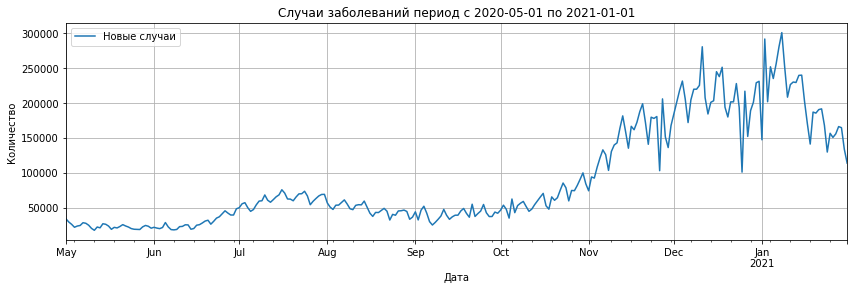

In [106]:
# Построил график среза за '2020-05-01':'2021-01-01'
data['2020-05-01':'2021-01-31'].resample('1D').sum().plot(figsize=(14,4), 
                                grid=True, 
                                xlabel='Дата',
                                ylabel='Количество',
                                title='Случаи заболеваний период с 2020-05-01 по 2021-01-01')
plt.legend(['Новые случаи'])
plt.show()

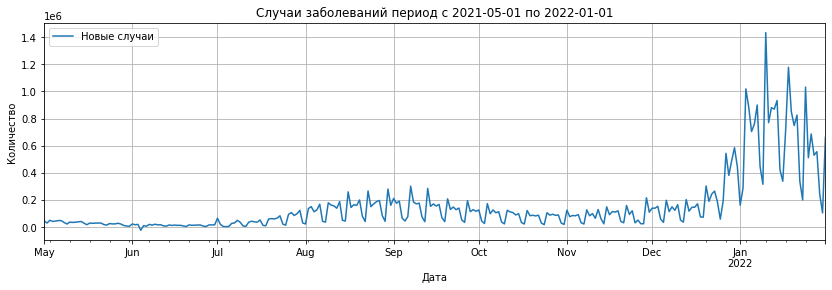

In [567]:
# Построил график среза за '2021-05-01':'2022-01-01'
data['2021-05-01':'2022-01-31'].resample('1D').sum().plot(figsize=(14,4), 
                               grid=True, 
                               xlabel='Дата',
                               ylabel='Количество',
                               title='Случаи заболеваний период с 2021-05-01 по 2022-01-01')
plt.legend(['Новые случаи'])
plt.show()

Продолжим работать со вторым графиком, тк он более наглядный

Внутри среза видна цикличность (06, 13, 20, 27) 

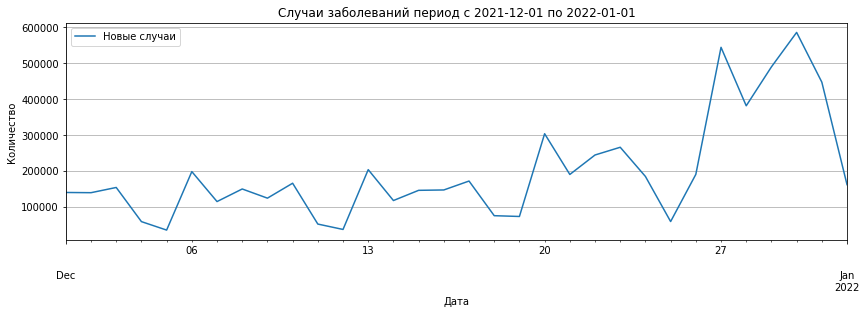

In [568]:
# Построил график среза за '2021-05-01':'2022-01-01'
data['2021-12-01':'2022-01-01'].resample('1D').sum().plot(figsize=(14,4), 
                               grid=True, 
                               xlabel='Дата',
                               ylabel='Количество',
                               title='Случаи заболеваний период с 2021-12-01 по 2022-01-01')
plt.legend(['Новые случаи'])
plt.show()

In [97]:
data['2021-12-06':'2022-12-06'].resample('1D').sum().index.dayofweek[0]

0

Получается, что пик новых зафиксированных случаев приходится на понедельеник

Это вполне логично, ведь после выходных все службы начинали работать в полную силу

In [555]:
# Сформировал матрицу признаков
data_copy = data.copy()

data_copy['month'] = data_copy.index.month
data_copy['day'] = data_copy.index.day
data_copy['dayofweek'] = data_copy.index.dayofweek
data_copy['rolling_mean'] = data_copy['cases'].shift().rolling(5).mean()
data_copy['std'] = data_copy['cases'].shift().rolling(5).std()
    
for lag in range(1, 12):
    data_copy[f'lag_{lag}'] = data_copy['cases'].shift(lag)

data_copy = data_copy.dropna()
data_copy.head(10)

,cases,month,day,dayofweek,rolling_mean,std,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
date,,,,,,,,,,,,,,,,,
2020-05-12,22300,5,12,1,23786.4,4694.193679,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0,23709.0,21962.0,26140.0,29474.0,33970.0
2020-05-13,21145,5,13,2,22550.8,3895.720562,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0,23709.0,21962.0,26140.0,29474.0
2020-05-14,26962,5,14,3,21250.2,2657.234408,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0,23709.0,21962.0,26140.0
2020-05-15,26237,5,15,4,21669.0,3424.280727,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0,23709.0,21962.0
2020-05-16,23659,5,16,5,22853.0,3838.366645,26237.0,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0,23709.0
2020-05-17,19014,5,17,6,24060.6,2495.824373,23659.0,26237.0,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0,24506.0
2020-05-18,21827,5,18,0,23403.4,3358.774226,19014.0,23659.0,26237.0,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0,28478.0
2020-05-19,20977,5,19,1,23539.8,3256.420535,21827.0,19014.0,23659.0,26237.0,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0,27648.0
2020-05-20,23070,5,20,2,22342.8,2743.608245,20977.0,21827.0,19014.0,23659.0,26237.0,26962.0,21145.0,22300.0,17621.0,20317.0,24868.0


In [556]:
# Разбил данные на тестовую и обучающую выборки
train, test = train_test_split(data_copy, shuffle=False, test_size=0.05)
train_features = train.drop('cases', axis=1)
train_target = train['cases']

test_features = test.drop('cases', axis=1)
test_target = test['cases']

In [569]:
# Протестировал модель линейной регрессии Lasso
parametrs = {'alpha': [0.1, 0.5, 1, 5, 10] }
model_lasso = Lasso()
cv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(model_lasso, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_lasso.set_params(**grid.best_params_)       
model_lasso.fit(train_features, train_target)         
predictions = model_lasso.predict(train_features)

rmse_lasso = mean_squared_error(train_target, predictions)**0.5
r2_lasso = r2_score(train_target, predictions)

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_lasso, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_lasso)

Оптимальные параметры:  {'alpha': 0.1}
RMSE на обучающей выборке:  54668.42068696846 
R2 на обучающей выборке:  0.8800900736697294


In [580]:
# Протестировал модель RandomForest
parametrs = {'n_estimators': range(100, 700, 100),
             'max_depth': range(5, 10, 1) }
model_rf = RandomForestRegressor()
cv = TimeSeriesSplit(n_splits=7, gap = 20)

grid = GridSearchCV(model_rf, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_rf.set_params(**grid.best_params_)       
model_rf.fit(train_features, train_target)          
predictions = model_rf.predict(train_features)

rmse_rf = mean_squared_error(train_target, predictions)**0.5
r2_rf = r2_score(train_target, predictions)

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_rf, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_rf)

Оптимальные параметры:  {'max_depth': 8, 'n_estimators': 500}
RMSE на обучающей выборке:  24140.560528040536 
R2 на обучающей выборке:  0.9766182625025079


In [595]:
# Протестировал модель GradientBoosting
parametrs = {'n_estimators': [100, 200, 500],
             'max_depth':  [3, 5, 7],
             'learning_rate': [0.01, 0.1, 0.5]}
model_gb = GradientBoostingRegressor()
cv = TimeSeriesSplit(n_splits=30, gap = 10)

grid = GridSearchCV(model_gb, parametrs, cv=cv, scoring='r2')
grid.fit(train_features, train_target)

print('\033[1mОптимальные параметры:\033[0m ', grid.best_params_)

model_gb.set_params(**grid.best_params_)       
model_gb.fit(train_features, train_target)    
predictions = model_gb.predict(train_features)

rmse_gb = mean_squared_error(train_target, predictions)**0.5
r2_gb = r2_score(train_target, predictions)

print('\033[1mRMSE на обучающей выборке:\033[0m ', rmse_gb, 
      '\n\033[1mR2 на обучающей выборке:\033[0m ', r2_gb)

Оптимальные параметры:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
RMSE на обучающей выборке:  2444.178965633962 
R2 на обучающей выборке:  0.9997603110100999


In [597]:
predictions_l = model_lasso.predict(test_features)

rmse_lasso = mean_squared_error(test_target, predictions_l)**0.5
r2_lasso = r2_score(test_target, predictions_l)

print('\033[1mLasso_RMSE на тестовой выборке:\033[0m ', rmse_lasso, 
      '\n\033[1mLasso_R2 на тестовой выборке:\033[0m ', r2_lasso)

predictions_rf = model_rf.predict(test_features)

rmse_rf = mean_squared_error(test_target, predictions_rf)**0.5
r2_rf = r2_score(test_target, predictions_rf)

print('\033[1mrf_RMSE на тестовой выборке:\033[0m ', rmse_rf, 
      '\n\033[1mrf_R2 на тестовой выборке:\033[0m ', r2_rf)

predictions_gb = model_gb.predict(test_features)

rmse_gb = mean_squared_error(test_target, predictions_gb)**0.5
r2_gb = r2_score(test_target, predictions_gb)

print('\033[1mgb_RMSE на тестовой выборке:\033[0m ', rmse_gb, 
      '\n\033[1mgb_R2 на тестовой выборке:\033[0m ', r2_gb)

Lasso_RMSE на тестовой выборке:  61717.03544059055 
Lasso_R2 на тестовой выборке:  0.7821504867132861
rf_RMSE на тестовой выборке:  240903.3917000966 
rf_R2 на тестовой выборке:  -2.319191499866514
gb_RMSE на тестовой выборке:  246592.52024869228 
gb_R2 на тестовой выборке:  -2.4778134210847145


In [590]:
best_prediction = predictions_l

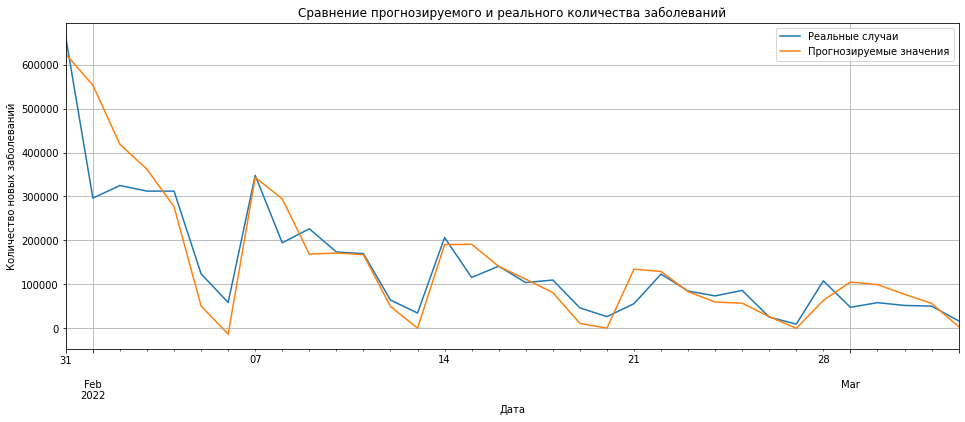

In [592]:
# Построил график реальных и прогнозируемых значений
data_pred = pd.DataFrame(test_target, index=test_target.index) 
data_pred['predictions_orders'] = best_prediction
data_pred.plot(figsize=(16,6), 
               grid=True,
               xlabel='Дата',
               ylabel='Количество новых заболеваний',
               title='Сравнение прогнозируемого и реального количества заболеваний')
plt.legend(['Реальные случаи', 'Прогнозируемые значения'])
plt.show()

Вывод:

В работе была подобрана модель для прогнозирования количества новых заболеваний covid в США. Для этого были протестированы несколько моделей регрессии с подбором оптимальных параметров, и на основе полученных результатов была выбрана модель лучшего качества.

Для обучения и тестирования модели данные были разбиты последовательно на тестовую и обучающую выборки, тестовая выборка составляет 5% от исходного ряда. Для подбора оптимальных параметров на обучающей выборке применялась кросс-валидация с последовательным разбиением данных.

Для оценки качества тестируемых моделей рассматривалась метрика RSME и R2. Несмотря на то, что на тренировочных данных модель Lasso показала самые плохие результаты. В результате тестирования лучшие метрики оказались именно у этой модели, а RandomForest и GradientBoosting оказались переобученны.